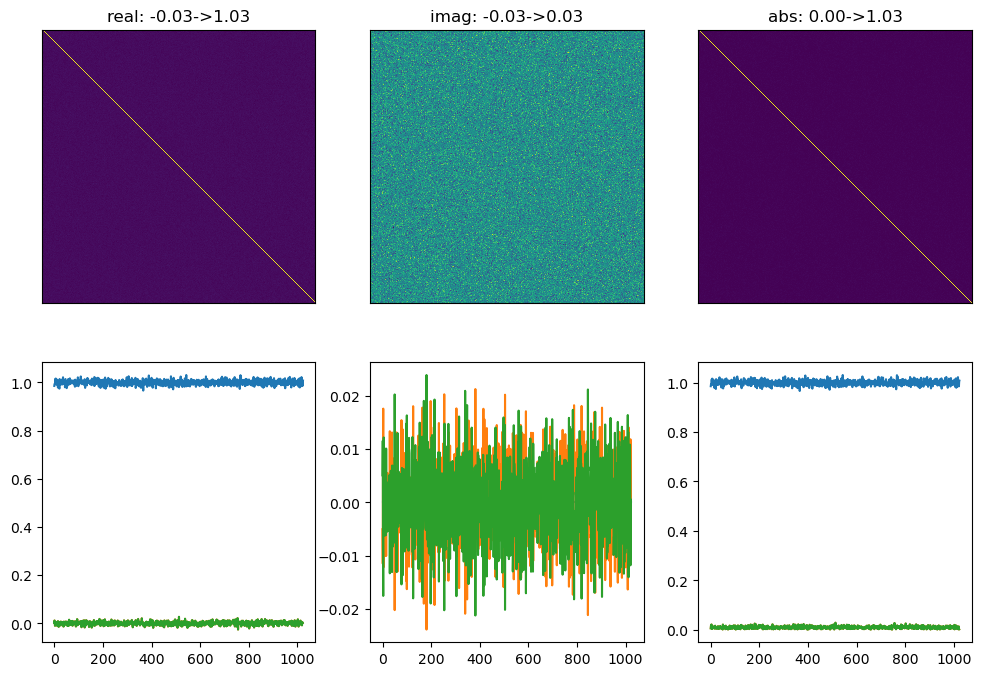

In [117]:
import numpy as np
import matplotlib.pyplot as plt
noise_sd = 1
npoints = 1024
nsamples = 10000
rng = np.random.default_rng()
original_noise = noise_sd / np.sqrt(2) * rng.standard_normal((npoints, nsamples)) + 1j * noise_sd / np.sqrt(2) * rng.standard_normal((npoints, nsamples))

original_cov = np.cov(original_noise)

def plot_cov(cov_mat: np.ndarray) -> plt.Figure:
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    axes[0, 0].matshow(np.real(cov_mat))
    axes[0, 1].matshow(np.imag(cov_mat))
    axes[0, 2].matshow(np.abs(cov_mat))
    for ax in axes[0]:
        ax.set_xticks([])
        ax.set_yticks([])

    for idx, name in enumerate([
            ('real', np.real), 
            ('imag', np.imag),
            ('abs', np.abs)]):
        axes[0, idx].set_title(f'{name[0]}: {np.min(name[1](cov_mat)):0.2f}->{np.max(name[1](cov_mat)):0.2f}')

    axes[1, 0].plot(np.diag(np.real(cov_mat)))
    axes[1, 0].plot(np.diag(np.real(cov_mat), k=1))
    axes[1, 0].plot(np.diag(np.real(cov_mat), k=-1))
    axes[1, 1].plot(np.diag(np.imag(cov_mat)))
    axes[1, 1].plot(np.diag(np.imag(cov_mat), k=1))
    axes[1, 1].plot(np.diag(np.imag(cov_mat), k=-1))
    axes[1, 2].plot(np.diag(np.abs(cov_mat)))
    axes[1, 2].plot(np.diag(np.abs(cov_mat), k=1))
    axes[1, 2].plot(np.diag(np.abs(cov_mat), k=-1))
    plt.show()
    return fig

fig = plot_cov(original_cov)

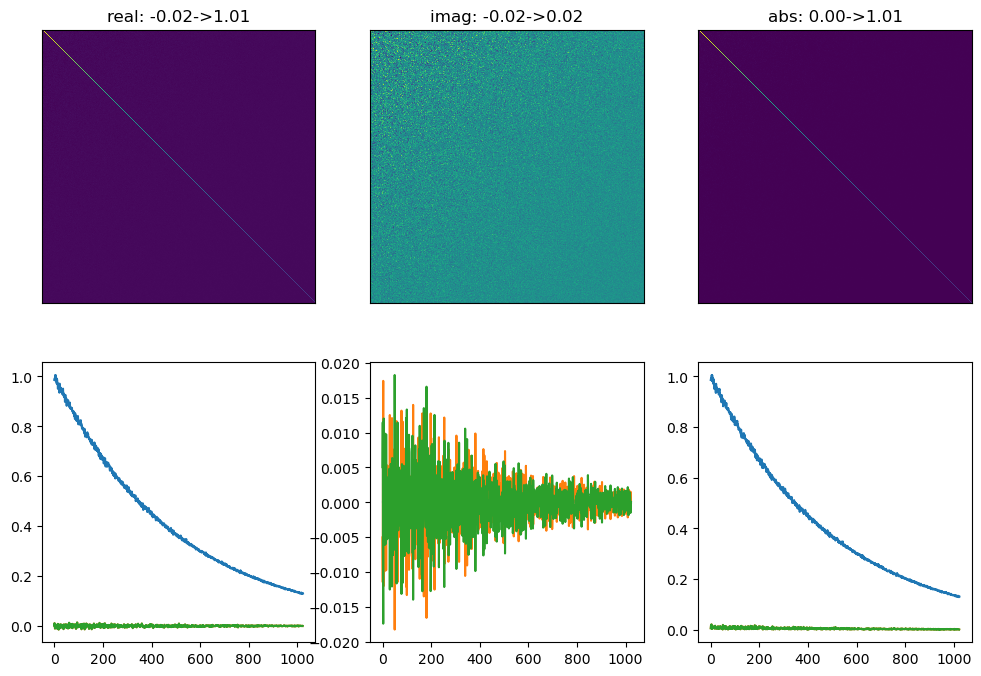

In [118]:
def apod_window(size: int, dwelltime: float, broadening: float) -> np.ndarray:
    taxis = np.linspace(0, dwelltime * (size - 1), size)
    Tl = 1 / broadening
    return np.exp(-taxis / Tl)

def apodise(data: np.ndarray, dwelltime: float, broadening: float) -> np.ndarray:
    window = apod_window(data.shape[0], dwelltime, broadening)
    return window[:, np.newaxis] * data

apodised_noise = apodise(original_noise, 1, 0.001)

apodised_cov = np.cov(apodised_noise)

fig = plot_cov(apodised_cov)

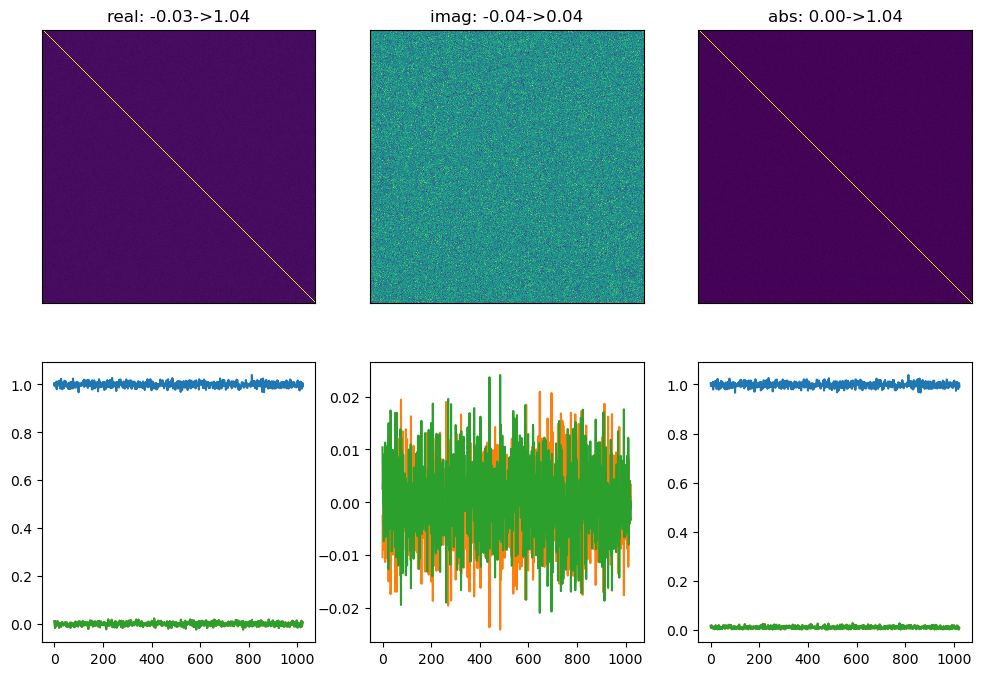

In [119]:
from fsl_mrs.utils.misc import FIDToSpec
fft_noise = FIDToSpec(original_noise, axis=0)
fft_cov = np.cov(fft_noise)

fig = plot_cov(fft_cov)

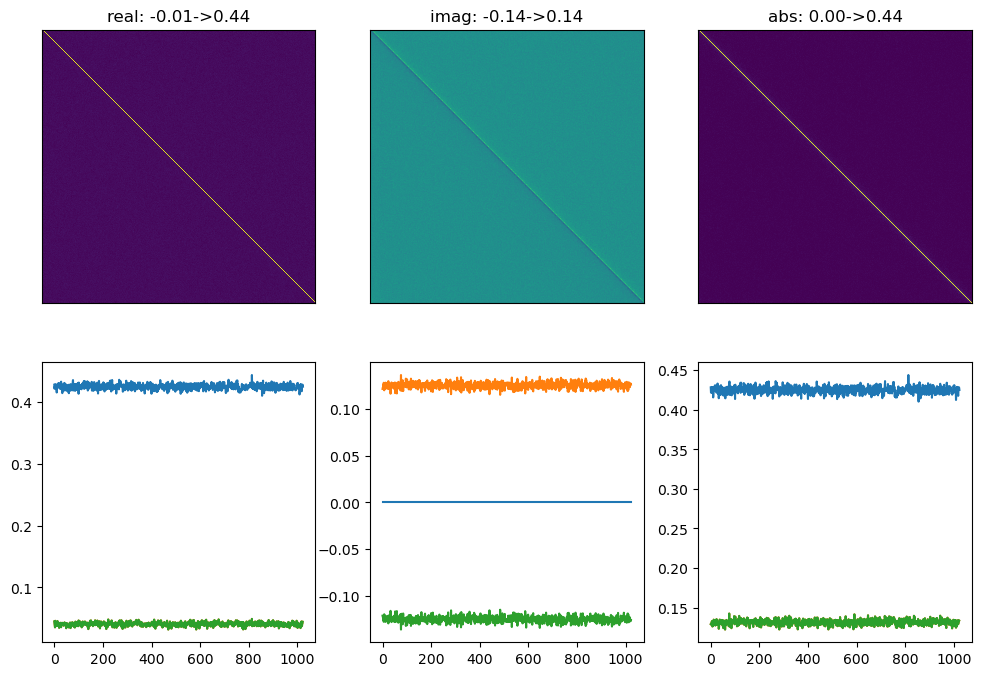

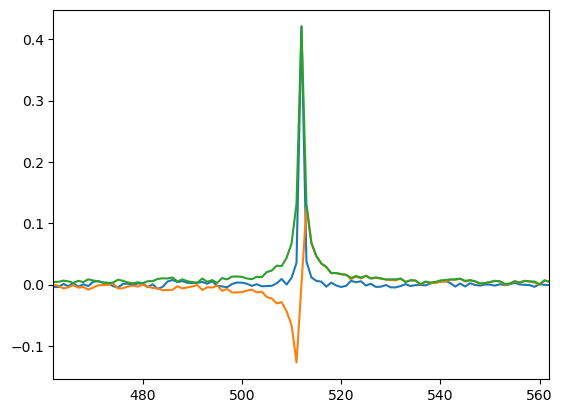

In [120]:
fft_apod_noise = FIDToSpec(apodised_noise, axis=0)
fft_apod_cov = np.cov(fft_apod_noise)

fig = plot_cov(fft_apod_cov)

plt.plot(fft_apod_cov.real[512,:])
plt.plot(fft_apod_cov.imag[512,:])
plt.plot(np.abs(fft_apod_cov)[512,:])
plt.xlim([512-50, 512+50])
plt.show()

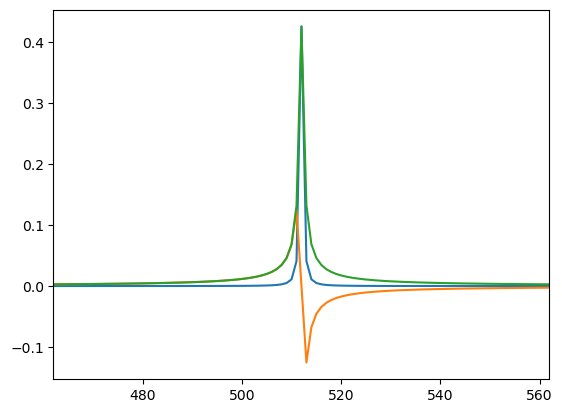

In [122]:
window = apod_window(npoints, 1, 0.001)
fft_ortho_scale_factor = 1 / np.sqrt(npoints)
scaled_fft_window = FIDToSpec(window ** 2) * noise_sd**2 * fft_ortho_scale_factor
plt.plot(scaled_fft_window.real)
plt.plot(scaled_fft_window.imag)
plt.plot(np.abs(scaled_fft_window))
plt.xlim([512-50, 512+50])
plt.show()

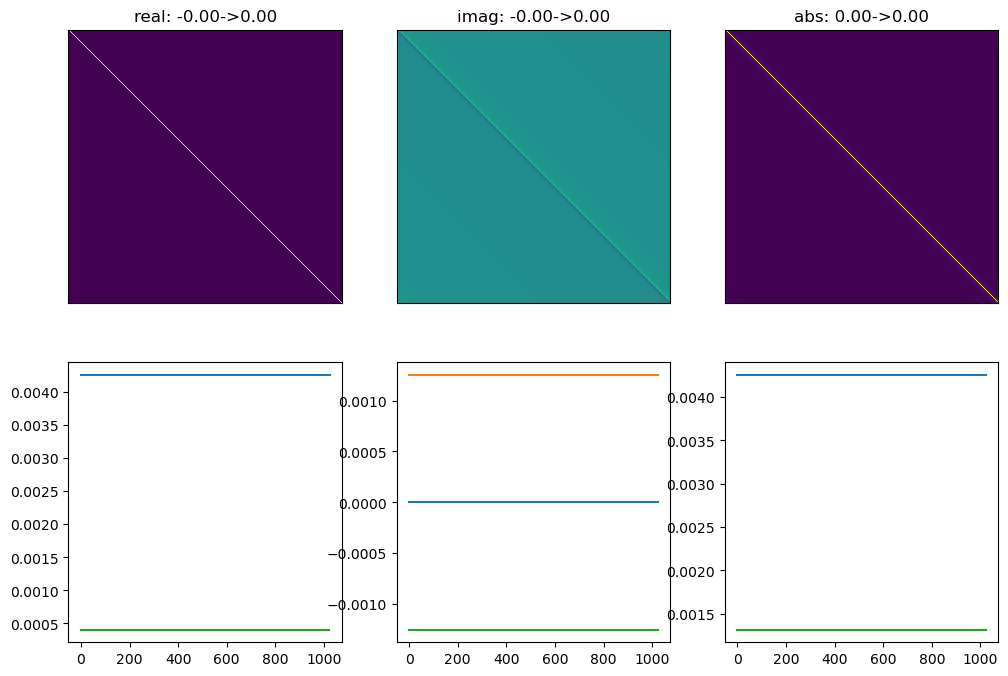

In [145]:
from scipy.linalg import circulant
def make_windowed_cov(window: np.array, noise_sd: float) -> np.ndarray:
    fft_ortho_scale_factor = 1 / np.sqrt(window.size)
    scaled_fft_window = FIDToSpec(window ** 2) * noise_sd ** 2 * fft_ortho_scale_factor
    return circulant(np.fft.fftshift(scaled_fft_window))
direct_cov = make_windowed_cov(
    apod_window(npoints, 1, 0.001),
    noise_sd
)
fig = plot_cov(direct_cov)

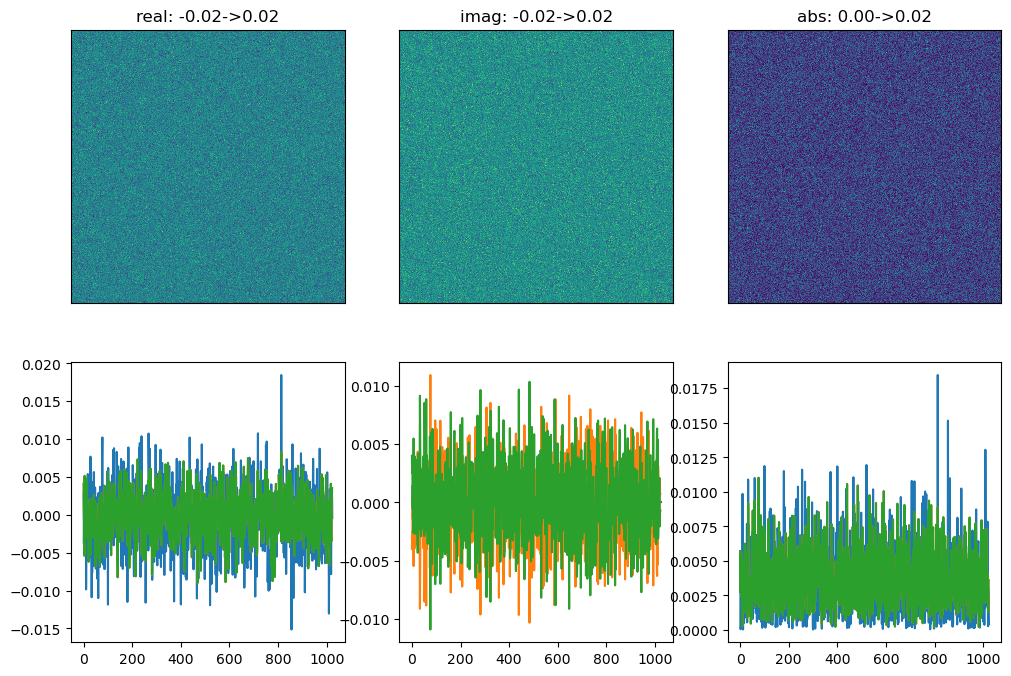

In [124]:
fig = plot_cov(fft_apod_cov-direct_cov)

## Whitening

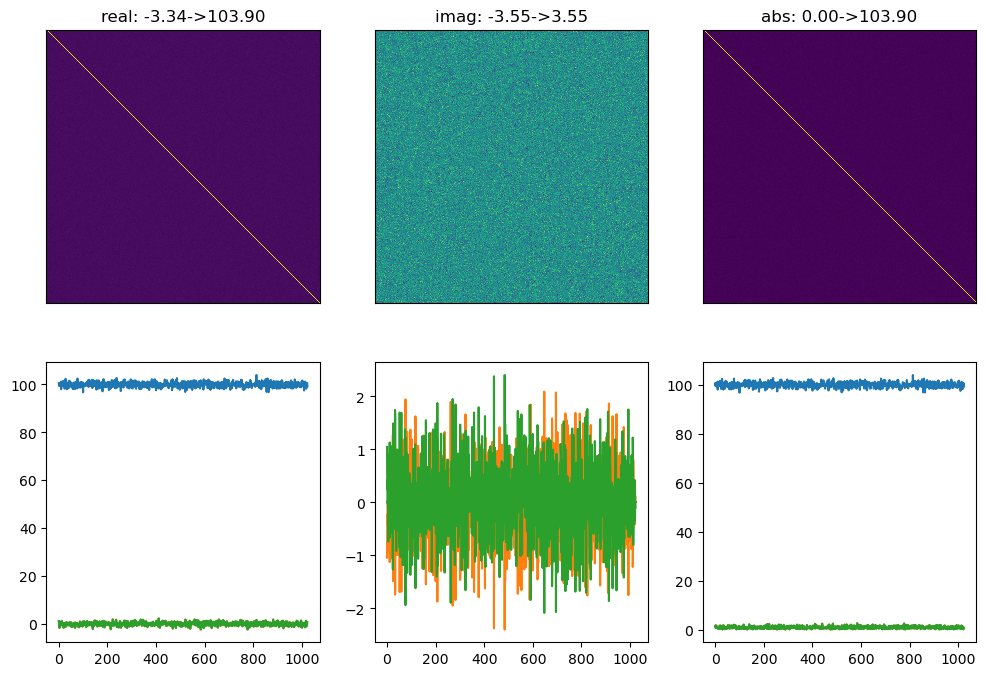

In [146]:
def zca_whiten(data: np.ndarray, cov: np.ndarray) -> np.ndarray:
    """Applies ZCA whitening to spectral data

    :param data: 2D array of spectra, (optional) repeats x spectral points
    :type data: np.ndarray
    :param cov: coloured covariance matrix
    :type cov: np.ndarray
    :return: whitened data, (optional) repeats x spectral points
    :rtype: np.ndarray
    """

    eigs, U = np.linalg.eigh(cov)

    eigs = np.maximum(eigs, 1E-15)

    W_zca = U @ np.diag(1/np.sqrt(eigs)) @ U.conj().T

    return data @ W_zca.T 

fft_apod_noise_whiten = zca_whiten(fft_apod_noise.T, direct_cov).T

fft_apod_whiten_cov = np.cov(fft_apod_noise_whiten)

fig = plot_cov(fft_apod_whiten_cov)

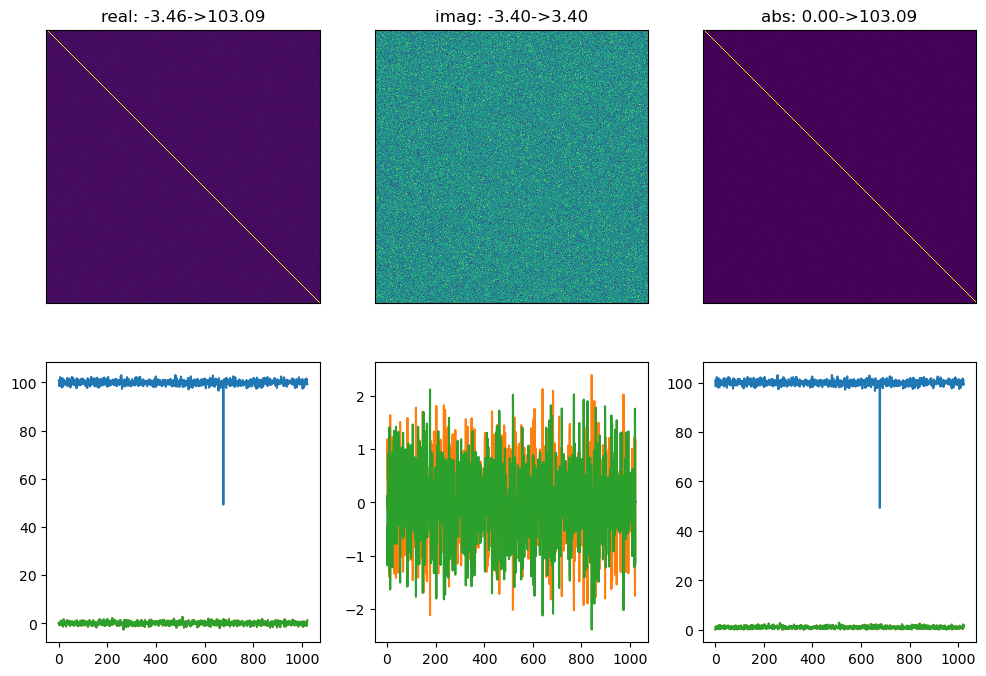

In [159]:

def pca_whiten(data: np.ndarray, cov: np.ndarray) -> np.ndarray:
    """Applies PCA whitening to spectral data

    :param data: 2D array of spectra, (optional) repeats x spectral points
    :type data: np.ndarray
    :param cov: coloured covariance matrix
    :type cov: np.ndarray
    :return: whitened data, (optional) repeats x spectral points
    :rtype: np.ndarray
    """

    eigs, U = np.linalg.eigh(cov)

    eigs = np.maximum(eigs, 1E-8)

    W_pca = np.diag(1.0/np.sqrt(eigs)) @ U.conj().T

    return data @ W_pca.T 

fft_apod_noise_whiten = pca_whiten(fft_apod_noise.T, direct_cov).T

fft_apod_whiten_cov = np.cov(fft_apod_noise_whiten)

fig = plot_cov(fft_apod_whiten_cov)

Original STD = 0.1 (var = 0.010)
0.009953906566516763
0.009953906566516759
0.009956283073617456
0.09976926664317405
0.09976926664317404
0.09978117594825918


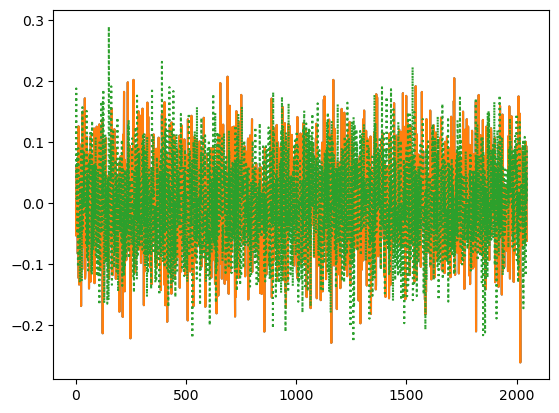

In [153]:
from fsl_mrs.utils.synthetic import syntheticFID

noise_sd = np.sqrt(0.01)
noise_sd_single_channel = noise_sd / np.sqrt(2)
print(f'Original STD = {noise_sd} (var = {noise_sd**2:0.03f})')
fid, headers = syntheticFID(
    noisecovariance=[[noise_sd_single_channel**2]],
    amplitude=[0,0]
)

def apodise_w(data: np.ndarray, dwelltime: float, broadening: float) -> np.ndarray:
    window = apod_window(data.shape[0], dwelltime, broadening)
    return window[:, np.newaxis] * data, window

apod_amount = 1E-15

windowed_fid, window_applied = apodise_w(fid[0][:, np.newaxis], headers['dwelltime'], apod_amount)

cov_mat_est = make_windowed_cov(
        window_applied,
        noise_sd)

# cov_mat_est = np.eye(windowed_fid.shape[0])

whitened_spec = noise_sd * pca_whiten(
    FIDToSpec(windowed_fid).T, 
    cov_mat_est).T

print(np.var(FIDToSpec(fid[0])))
print(np.var(FIDToSpec(windowed_fid)))
print(np.var(whitened_spec))

print(np.std(FIDToSpec(fid[0])))
print(np.std(FIDToSpec(windowed_fid)))
print(np.std(whitened_spec))


plt.plot(FIDToSpec(fid[0]).real)
plt.plot(FIDToSpec(windowed_fid).real)
plt.plot(whitened_spec.real,':')

plt.show()

Original STD = 0.1 (var = 0.010)


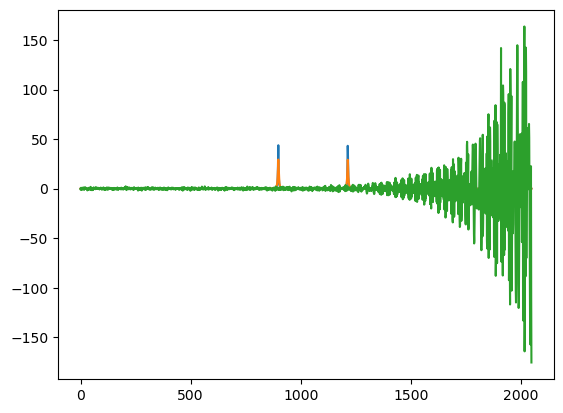

In [167]:
noise_sd = np.sqrt(0.01)
noise_sd_single_channel = noise_sd / np.sqrt(2)
print(f'Original STD = {noise_sd} (var = {noise_sd**2:0.03f})')
fid, headers = syntheticFID(
    noisecovariance=[[noise_sd_single_channel**2]],
    amplitude=[10,10])

def apodise_w(data: np.ndarray, dwelltime: float, broadening: float) -> np.ndarray:
    window = apod_window(data.shape[0], dwelltime, broadening)
    return window[:, np.newaxis] * data, window

apod_amount = 10

windowed_fid, window_applied = apodise_w(fid[0][:, np.newaxis], headers['dwelltime'], apod_amount)

cov_mat_est = make_windowed_cov(
        window_applied,
        noise_sd)

# cov_mat_est = np.eye(windowed_fid.shape[0])

whitened_spec = pca_whiten(
    FIDToSpec(windowed_fid).T, 
    cov_mat_est).T

# fig = plot_cov(cov_mat_est)
# plt.show()

plt.figure()
plt.plot(FIDToSpec(fid[0]).real)
plt.plot(FIDToSpec(windowed_fid).real)
plt.plot(whitened_spec.real)
# plt.xlim([750, 1250])
# plt.ylim([-1, 2])
plt.show()